In [13]:
# Growth Area Coordinates
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import hvplot.pandas
from config import geoapify_key
print (geoapify_key)

d5037d604961461b9a3e13edebf3d8ec


In [2]:
growth_data = pd.read_csv("Output/grmelbourne_growth_byarea.csv")
ptv_data = pd.read_csv("Output/PTV_suburb.csv")
suburb_list = pd.DataFrame (growth_data[["Area Name"]])
# suburb_list=suburb_list.sample(5)


In [3]:
# !!!!!!!!!!!!!!!
# In stead of running this script you can import the CSV for the rest




base_url = "https://api.geoapify.com/v1/geocode/search"
params = {
    "apiKey":geoapify_key,
    "format":"json"
            }

for index, row in suburb_list.iterrows():
    area = row["Area Name"] + ",Vic,Australia"
    params["text"] = f"{area}"
    response = requests.get(base_url, params=params).json()
    # response = response.json()
    try:
        suburb_list.loc[index, "Lat"] = response["results"][0]["lat"]
        suburb_list.loc[index, "Lon"] = response["results"][0]["lon"]
        suburb_list.loc[index, "place_id"] = response["results"][0]["place_id"]
        suburb_list.loc[index, "addr_1"] = response["results"][0]["address_line1"]
        suburb_list.loc[index, "addr-2"] = response["results"][0]["address_line1"]
        suburb_list.loc[index, "Confidence"] = response["results"][0]["rank"]["confidence"]
        suburb_list.loc[index, "Municipality"] = response["results"][0]["municipality"]
        suburb_list.loc[index, "Suburb_geoapify"] = response["results"][0]["suburb"]
        suburb_list.loc[index, "bbox_lat1"] = response["results"][0]["bbox"]["lat1"]
        suburb_list.loc[index, "bbox_lat2"] = response["results"][0]["bbox"]["lat2"]
        suburb_list.loc[index, "bbox_lon1"] = response["results"][0]["bbox"]["lon1"]
        suburb_list.loc[index, "bbox_lon2"] = response["results"][0]["bbox"]["lon2"]

    except KeyError as e:
       
        print(f"{e.args[0]} results not found for {suburb_list.loc[index, 'Area Name']}")
    
# print(json.dumps(response, indent=4, sort_keys=True))



suburb results not found for Bunyip
suburb results not found for Garfield
suburb results not found for Cockatoo
suburb results not found for Flinders
suburb results not found for Gisborne
suburb results not found for Hastings
municipality results not found for Hillside
suburb results not found for Koo Wee Rup
suburb results not found for Macedon
municipality results not found for Point Nepean
suburb results not found for Riddells Creek
suburb results not found for Romsey
suburb results not found for Sunbury
suburb results not found for Whittlesea


In [4]:
# drop if confidence level is less than 1
suburb_list=suburb_list[suburb_list["Confidence"]==1]

# drop outliers
remove =["Hillside", "Bunyip", "Garfield","Point Nepean"]
suburb_list = suburb_list[~suburb_list["Area Name"].isin(remove)]
# rename greenvale - bulla to greenvale (will miss 84 bulla ptv trips)
suburb_list['Area Name'] = suburb_list['Area Name'].replace("Greenvale - Bulla","Greenvale")

growth_mapped_geopafy =pd.merge(growth_data, suburb_list, how ="right", on="Area Name")


In [5]:
# save csv file
growth_mapped_geopafy.to_csv("Output/growth_mapped_geopafy.csv")

In [8]:
map_plot1 = growth_mapped_geopafy.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 800,
    frame_height = 400,
    size = "Total Growth",
    scale = 0.04,
    color = "Area Name"
)

map_plot1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (Area Name,Total Growth)

In [9]:
total_growth_fromscsv = growth_data["Total Growth"].sum()
# print(total_growth_fromscsv)
# growth_data['Total Growth']=growth_data['Total Growth'].str.replace(',','')
# growth_data['Total 2016'] = growth_data['Total 2016'].astype('float')
total_growth_mapped = growth_mapped_geopafy["Total Growth"].sum()
# print (total_growth_mapped)
percentage_growth_mapped = (total_growth_mapped/total_growth_fromscsv)*100
percentage_growth_mapped = f"{percentage_growth_mapped:.2f}%"
total_growth_fromscsv=f"{total_growth_fromscsv:,.0f}"
# total_growth_froms_csv = f"{total_growth_froms_csv:,}"

print (f"We were able to map {percentage_growth_mapped} of the total growth of {total_growth_fromscsv} reported by Victoria")

We were able to map 97.36% of the total growth of 2,120,566 reported by Victoria


In [10]:

suburb_growth_bins=growth_mapped_geopafy.copy()
growth_bins=[0,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 10]
labels=["<30%","$40%","50%", "60%", "70%", "80%","90%",">100%"]
suburb_growth_bins["Growth % per suburb"]=pd.cut(suburb_growth_bins['Total Growth %'], growth_bins, labels=labels)

suburb_growth_bins_count = suburb_growth_bins.groupby(["Growth % per suburb"]).count()["Total Growth %"]
suburb_growth_bins_total = suburb_growth_bins.groupby(["Growth % per suburb"]).sum()["Total Growth"]
suburb_growth_bins_average = suburb_growth_bins.groupby(["Growth % per suburb"]) ["Total Growth"].mean()
suburb_growth_bins_perc = suburb_growth_bins.groupby(["Growth % per suburb"]) ["Total Growth %"].mean()

suburb_growth_bins = pd.DataFrame({"Number of growth areas":suburb_growth_bins_count,"Total Growth":suburb_growth_bins_total ,"Average Growth":suburb_growth_bins_average, "Average Growth %":suburb_growth_bins_perc })
suburb_growth_bins

,Number of growth areas,Total Growth,Average Growth,Average Growth %
Growth % per suburb,,,,
<30%,167,451320.0,2702.514970,0.161377
$40%,34,210914.0,6203.352941,0.347353
50%,20,154937.0,7746.850000,0.446500
60%,17,234057.0,13768.058824,0.545882
70%,8,74420.0,9302.500000,0.648750
80%,6,98348.0,16391.333333,0.763333
90%,2,27480.0,13740.000000,0.835000
>100%,18,696330.0,38685.000000,2.116667


In [11]:
over_100perc_growth = growth_mapped_geopafy.loc[growth_mapped_geopafy["Total Growth %"]>=1]
map_plot2 = over_100perc_growth.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    size = "Total Growth",
    scale = 0.04,
    color = "Area Name"
)
map_plot2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (Area Name,Total Growth)

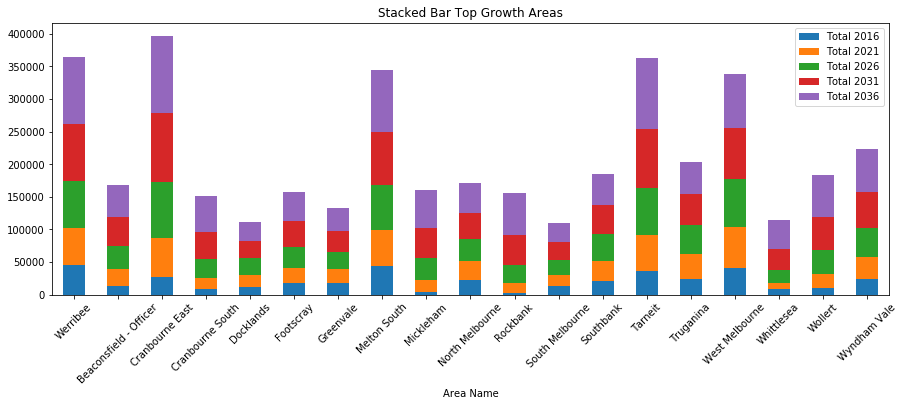

In [17]:
# xaxis = over_100perc_growth['Area Name']
# yaxis = over_100perc_growth['Total 2036']
# plt.scatter(xaxis,yaxis)
# plt.xlabel("Area")
# plt.ylabel("Population")
# plt.show()
top_stacked = over_100perc_growth[["Area Name", "Total 2016","Total 2021","Total 2026","Total 2031","Total 2036"]]
 
# plot data in stack manner of bar type
top_stacked.plot(x='Area Name', kind='bar', stacked=True,figsize=(15,5), rot=45,
        title='Stacked Bar Top Growth Areas')
plt.show()

In [30]:
ptv_trip = pd.read_csv("Resources/P1_trip_frequency_adjRAVV.csv")
ptv_trip.head()

top_growth_ptv_merge = pd.merge(over_100perc_growth, ptv_trip, how = "left", left_on="Area Name", right_on="Suburb")

top_growth_ptv_merge=top_growth_ptv_merge[["Area Name","Total 2016", "Total 2036","Total Growth", "Total Growth %","Grand Total", "trips_per_stop"]]
top_growth_ptv_merge["Stops"] = top_growth_ptv_merge["Grand Total"]/top_growth_ptv_merge["trips_per_stop"]
top_growth_ptv_merge["Stops_pp_2016"]=top_growth_ptv_merge["Total 2016"] / top_growth_ptv_merge["Stops"]
top_growth_ptv_merge["Stops_pp_2036"]=top_growth_ptv_merge["Total 2036"] / top_growth_ptv_merge["Stops"]
top_growth_ptv_merge["Increasee stops pp %"] = ((top_growth_ptv_merge["Stops_pp_2036"]-top_growth_ptv_merge["Stops_pp_2016"])/top_growth_ptv_merge["Total 2016"])*100
top_growth_ptv_merge

,Area Name,Total 2016,Total 2036,Total Growth,Total Growth %,Grand Total,trips_per_stop,Stops,Stops_pp_2016,Stops_pp_2036,Increasee stops pp %
0,Werribee,44702.0,102930.0,58228.0,1.30,8068,35.541850,227.0,196.925110,453.436123,0.573824
1,Beaconsfield - Officer,13612.0,49252.0,35640.0,2.62,1372,31.906977,43.0,316.558139,1145.395349,6.089019
2,Cranbourne East,26754.0,118601.0,91847.0,3.43,3990,83.125000,48.0,557.375000,2470.854167,7.152124
3,Cranbourne South,9116.0,54603.0,45487.0,4.99,624,89.142857,7.0,1302.285714,7800.428571,71.282831
4,Docklands,11832.0,29157.0,17325.0,1.46,6856,285.666667,24.0,493.000000,1214.875000,6.101040
5,Footscray,17343.0,44492.0,27149.0,1.57,11522,100.191304,115.0,150.808696,386.886956,1.361231
6,Greenvale,17123.0,35127.0,18004.0,1.05,2371,35.924242,66.0,259.439394,532.227273,1.593108
7,Melton South,43803.0,95148.0,51345.0,1.17,1952,41.531915,47.0,931.978723,2024.425532,2.494000
8,Mickleham,3580.0,58334.0,54754.0,15.29,2764,58.808511,47.0,76.170213,1241.148936,32.541305
9,North Melbourne,22106.0,45392.0,23286.0,1.05,6891,127.611111,54.0,409.370370,840.592593,1.950702
